In [1]:
%load_ext autoreload
%autoreload 2


import time
import joblib
import random
import clipboard
import config
import numpy as np
import math
from itertools import repeat
from operator import attrgetter
from deap import base, tools, creator, algorithms
try:
    from collections.abc import Sequence
except ImportError:
    from collections import Sequence
import pandas as pd
import csv
import sys

# GA

In [2]:
def get_boiler_inflection_points(num_radiators, max_energy_consumption_coefficient):
  boiler_inflection_point_list = [
    float(num_radiators * max_energy_consumption_coefficient * (1 / 6)),
    float(num_radiators * max_energy_consumption_coefficient * (1 / 2))
  ]
  return np.array(boiler_inflection_point_list)
"""

def get_boiler_inflection_points(num_radiators, max_energy_consumption_coefficient):
  boiler_inflection_point_list = [
    float(0.25),
    float(0.35)
  ]
  return np.array(boiler_inflection_point_list)
"""
"""
def optimal(i,j):
  return qc_gurobi_code.z_list[i:j-1,:len(qc_gurobi_code.z_list)-1]
"""

def get_temperature_prediction_coefficients(num_radiators):
  temp_pred_coef_list = [[-.175469, 0, 15.095, 15.49728, 15.89319]] * num_radiators # 12.01728
  return np.array(temp_pred_coef_list).T


def calculate_delta_temp_list(
  curr_temp_list, 
  target_temp_list
):
  return target_temp_list - curr_temp_list


def set_modulation_list(
  curr_temp_list, 
  target_temp_list, 
  valve_modulation_limit_list
):
  delta_temp_list = calculate_delta_temp_list(curr_temp_list, target_temp_list)
  modulations = []
  for i in range(delta_temp_list.shape[0]):
    delta_temp = delta_temp_list[i]

    if delta_temp <= valve_modulation_limit_list[0]:
      modulations.append(0)
    elif valve_modulation_limit_list[0] <= delta_temp <= valve_modulation_limit_list[1]:
      modulations.append(1)
    elif valve_modulation_limit_list[1] <= delta_temp <= valve_modulation_limit_list[2]:
      modulations.append(2)
    elif valve_modulation_limit_list[2] <= delta_temp <= 10:
      modulations.append(3)
  return np.array(modulations)


def calculate_energy_consumption_list(
  valve_modulation_energy_consumption_list, 
  valve_modulation_list
):
  return valve_modulation_energy_consumption_list[valve_modulation_list]


def predict_temperature_with_regression(
  target_temp_list, 
  curr_temp_list, 
  demand_total_time_x, 
  supply_granularity, 
  valve_modulation_limit_list, 
  temperature_prediction_coef_list, 
  num_radiators, 
  valve_modulation_energy_consumption_list
):
  hum_pred = 44
  iter_curr_temp_list = curr_temp_list.copy()
  temperature_prediction_list = list()
  energy_consumption_list = list()
  for t in range(demand_total_time_x):
    target_temp_list_at_t = target_temp_list[:, int(t / supply_granularity)]
    if any([i not in [0, 1, 2, 3] for i in target_temp_list_at_t]):
      valve_modulation_list = set_modulation_list(
        iter_curr_temp_list, 
        target_temp_list_at_t, 
        valve_modulation_limit_list
      )
    else:
      valve_modulation_list = target_temp_list_at_t
    
    temp_prediction_coef_list_over_hum_pred = temperature_prediction_coef_list[1:5] / hum_pred
    temp_diff_pred = np.array(
      [
        temp_prediction_coef_list_over_hum_pred[valve_modulation_list[f], f] 
        for f in range(num_radiators)
      ]
    ) + temperature_prediction_coef_list[0] / hum_pred
    iter_curr_temp_list += temp_diff_pred
    temperature_prediction_list.append(iter_curr_temp_list.copy())
    valve_energy_consumption_list = calculate_energy_consumption_list(
      valve_modulation_energy_consumption_list, 
      valve_modulation_list
    )
    energy_consumption_list.append(valve_energy_consumption_list.copy())
  return np.array(temperature_prediction_list).T, np.array(energy_consumption_list).T


def generate_individual(
  supply_total_time
):
  ind = np.random.choice(
    [0, 1, 2, 3], 
    p = [0.6, 0.25, 0.10, 0.05],
    size=(supply_total_time, )
  )
  return ind

"""
def crossover(
  ind1,
  ind2,
  cx_apartment_proba,
  cx_time_point_proba
):
  apartment_length, time_length = ind1.shape
  if (random.random() < 1/((config.x)**(1/6))):
    for i in range(apartment_length):
      if random.random() < cx_apartment_proba:
        if random.random() < 0.2:
          indices = random.sample(range(time_length), 2)
          t0 = min(indices)
          t1 = max(indices)

          ind1_val = ind1[i][t0 : t1]
          ind2_val = ind2[i][t0 : t1]

          ind1[i][t0 : t1] = ind2_val
          ind2[i][t0 : t1] = ind1_val
        else:
          for j in range(time_length):
            if random.random() < cx_time_point_proba:
              ind1_val = ind1[i][j]
              ind2_val = ind2[i][j]

              ind1[i][j] = ind2_val
              ind2[i][j] = ind1_val

  return ind1, ind2
"""

def crossover(
  ind1,
  ind2,
  cx_apartment_proba,
  cx_time_point_proba
):
  apartment_length, time_length = ind1.shape
  
  for i in range(apartment_length):
    if random.random() < cx_apartment_proba:
      if random.random() < 0.2:
        indices = random.sample(range(time_length), 2)
        t0 = min(indices)
        t1 = max(indices)

        ind1_val = ind1[i][t0 : t1]
        ind2_val = ind2[i][t0 : t1]

        ind1[i][t0 : t1] = ind2_val
        ind2[i][t0 : t1] = ind1_val
      else:
        for j in range(time_length):
          if random.random() < cx_time_point_proba:
            ind1_val = ind1[i][j]
            ind2_val = ind2[i][j]

            ind1[i][j] = ind2_val
            ind2[i][j] = ind1_val

  return ind1, ind2
"""

def crossover(
  ind1,
  ind2,
  cx_apartment_proba,
  cx_time_point_proba
):
  apartment_length, time_length = ind1.shape
  
  if (random.random() < math.exp(-abs(ind1.fitness.values[0] - ind2.fitness.values[0])/((config.x)))):
    for i in range(apartment_length):
      if random.random() < cx_apartment_proba:
        if random.random() < 0.2:
          indices = random.sample(range(time_length), 2)
          t0 = min(indices)
          t1 = max(indices)
          
          if(random.random() < 0.5):
            ind1_val1 = ind1[i][: t0]
            ind1_val2 = ind2[i][t0: t1]
            ind1_val3 = ind1[i][t1:]

            ind2_val1 = ind2[i][:t0]
            ind2_val2 = ind1[i][t0: t1]
            ind2_val3 = ind2[i][t1:]

            ind1[i][:t0] = ind2_val1
            ind1[i][t0 : t1] = ind2_val2
            ind1[i][t1: ] = ind2_val3

            ind2[i][: t0] = ind1_val1
            ind2[i][t0 : t1] = ind1_val2
            ind2[i][t1:] = ind1_val3



          else:
            ind2_val1 = ind1[i][0: t0]
            ind2_val2 = ind2[i][t0: t1]
            ind2_val3 = ind1[i][t1:]

            ind1_val1 = ind2[i][0: t0]
            ind1_val2 = ind1[i][t0: t1]
            ind1_val3 = ind2[i][t1:]

            ind1[i][: t0] = ind2_val1
            ind1[i][t0 : t1] = ind2_val2
            ind1[i][t1: ] = ind2_val3

            ind2[i][: t0] = ind1_val1
            ind2[i][t0 : t1] = ind1_val2
            ind2[i][t1:] = ind2_val3

        else:
          for j in range(time_length):
            if random.random() < cx_time_point_proba:
              ind1_val = ind1[i][j]
              ind2_val = ind2[i][j]

              ind1[i][j] = ind2_val
              ind2[i][j] = ind1_val

  return ind1, ind2
"""


def mutate(
  individual, 
  lower_limit, 
  upper_limit, 
  mutation_apartment_proba,
  mutation_time_point_proba
):
  apartment_length, time_length = individual.shape
  for i in range(apartment_length):
    if random.random() < mutation_apartment_proba:
      for j in range(time_length):
        if random.random() < mutation_time_point_proba:
          val = individual[i][j]
            
          if random.random() < 0.2:
            new_val = np.random.choice(
              [0, 1, 2, 3],
              p = [0.4, 0.3, 0.2, 0.1]
              )
          else:
            if val == lower_limit:
              new_val = lower_limit + 1
            elif val == upper_limit:
              new_val = upper_limit - 1
            else:
              new_val = val + np.random.choice([-1, 1])

          individual[i][j] = new_val
  return individual,



def selection(
  individuals, 
  k, 
  fit_attr="fitness"
):
  best_selection_alpha = 0.8
  sorted_individuals = sorted(individuals, key=attrgetter(fit_attr), reverse=True)

  selected_best = tools.selBest(
    individuals,
    int(k * best_selection_alpha), 
    fit_attr=fit_attr
  )
  selected_random = tools.selRandom(
    sorted_individuals[int(len(individuals) * best_selection_alpha) :], 
    int(k * (1 - best_selection_alpha))
  )
  return selected_best + selected_random

"""
def selection(
  individuals, 
  k, 
  fit_attr="fitness"
):
  worst_selection_alpha = 0.2
  sorted_individuals = sorted(individuals, key=attrgetter(fit_attr), reverse=True)

  selected_worst = tools.selWorst(
    individuals,
    int(k * worst_selection_alpha), 
    fit_attr=fit_attr
  )
  selected_random = tools.selRandom(
    sorted_individuals[int(len(individuals) * worst_selection_alpha) :], 
    int(k * (worst_selection_alpha))
  )
  return individuals - selected_worst + selected_random
"""


def split_data(current_temp_list, demanded_temp_list):
        asd = np.zeros(shape=(demanded_temp_list.shape[0], demanded_temp_list.shape[1]-1))
        for i in range (demanded_temp_list.shape[1]-1):
                if i == 0:
                        asd[:,0] = current_temp_list-demanded_temp_list[:,0]
                else:
                        asd[:,i] = demanded_temp_list[:,i+1]-demanded_temp_list[:,i]
        index_list = []
        print((asd >= 0))
        for i in range (asd.shape[1]):
                q = (asd[:,i] >= 0)
                a = [True]*asd.shape[0]
                if ((q == a).all()):
                        print(i)
                        index_list.extend([i])
        return index_list


def calculate_unmet_demand(
  temperature_prediction_list, 
  demanded_temperature_list
):
  return temperature_prediction_list - demanded_temperature_list 


def calculate_rmse(
  li
):
  return np.sqrt((li ** 2).mean())


def calculate_custom_score(
  li
):
  temp_li = np.abs(li[li < -0.03]) #tolerans burada
  return (10 + 100 * (temp_li-0.03)).sum() #kare buradaydı fitness


def calculate_negative_unmet_demand(
  unmet_demand_list
):
  negative_unmet_demand_list = unmet_demand_list.copy()
  negative_unmet_demand_list[negative_unmet_demand_list > -0.03] = 0.0
  return negative_unmet_demand_list


def evaluate_unmet_demand_one_way(
  unmet_demand_list
):
  negative_unmet_demand_list = calculate_negative_unmet_demand(unmet_demand_list)
  return calculate_custom_score(negative_unmet_demand_list)


def evaluate_unmet_demand_two_way(
  unmet_demand_list
):
  return calculate_rmse(unmet_demand_list)


def evaluate_energy_consumption(
  energy_consumption_list, 
  boiler_inflection_point_list, 
  boiler_cost_list
):
  total_energy_consumption_list = energy_consumption_list.sum(axis=0)
  boiler_energy_consumption_cost_list = np.where(
    total_energy_consumption_list <= boiler_inflection_point_list[0], 
    boiler_cost_list[0],
    np.where(
      total_energy_consumption_list <= boiler_inflection_point_list[1], 
      boiler_cost_list[1], 
      boiler_cost_list[2]
    )
  )
  
#   boiler_energy_consumption_cost_list **= 10
  return boiler_energy_consumption_cost_list.sum()


def evaluate(
  target_temp_list, 
  curr_temp_list, 
  demand_total_time, 
  supply_granularity, 
  valve_modulation_limit_list, 
  temperature_prediction_coef_list, 
  num_radiators, 
  valve_modulation_energy_consumption_list, 
  demanded_temperature_list,
  boiler_inflection_point_list, 
  boiler_cost_list
):
  temperature_prediction_list, energy_consumption_list = predict_temperature_with_regression(
    target_temp_list, 
    curr_temp_list, 
    demand_total_time, 
    supply_granularity,
    valve_modulation_limit_list, 
    temperature_prediction_coef_list, 
    num_radiators,
    valve_modulation_energy_consumption_list
  )

  unmet_demand_list = calculate_unmet_demand(
    temperature_prediction_list, 
    demanded_temperature_list
  )
  demand_evaluation = evaluate_unmet_demand_one_way(unmet_demand_list)

  energy_consumption_evaluation = evaluate_energy_consumption(
    energy_consumption_list, 
    boiler_inflection_point_list, 
    boiler_cost_list
  )
  
  score = demand_evaluation + energy_consumption_evaluation

  return demand_evaluation, energy_consumption_evaluation


creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0)) #optimizasyonda equally weighted
creator.create("Individual", np.ndarray, fitness=creator.FitnessMin)


def genetic_solver_run(
  num_radiators, 
  population_size, 
  offspring_size, 
  crossover_proba, 
  cx_apartment_proba,
  cx_time_point_proba,
  mutation_proba, 
  mutation_apartment_proba, 
  mutation_time_point_proba,
  demand_granularity, 
  supply_granularity, 
  application_period, 
  data_unit_time, 
  generation_length, 
  valve_min_modulation,
  valve_max_modulation, 
  current_temperature_list, 
  demanded_temperature_list, 
  valve_modulation_limit_list, 
  valve_modulation_energy_consumption_list, 
  boiler_inflection_point_list, 
  boiler_cost_list,
  temperature_prediction_coef_list
):
  res_dict = dict()
  
  demand_total_time = int(application_period * demand_granularity)
  supply_total_time = int(application_period * demand_granularity / supply_granularity)
  
  demanded_temperature_list = np.repeat(
    demanded_temperature_list, 
    demand_granularity
  ).reshape(num_radiators, -1)
  
  res_dict["demanded_temperature_list"] = demanded_temperature_list
  
  current_practice_schedule_list = demanded_temperature_list
  
  current_practice_schedule_evaluation = evaluate(
    current_practice_schedule_list, 
    curr_temp_list=current_temperature_list, 
    demand_total_time=demand_total_time,
    supply_granularity=supply_granularity, 
    valve_modulation_limit_list=valve_modulation_limit_list, 
    temperature_prediction_coef_list=temperature_prediction_coef_list, 
    num_radiators=num_radiators,
    valve_modulation_energy_consumption_list=valve_modulation_energy_consumption_list, 
    demanded_temperature_list=demanded_temperature_list,
    boiler_inflection_point_list=boiler_inflection_point_list, 
    boiler_cost_list=boiler_cost_list
  )
  
  (
    current_practice_temperature_prediction_list, 
    current_practice_energy_consumption_list
  ) = predict_temperature_with_regression(
    current_practice_schedule_list,
    current_temperature_list, 
    demand_total_time, 
    supply_granularity, 
    valve_modulation_limit_list, 
    temperature_prediction_coef_list,
    num_radiators, 
    valve_modulation_energy_consumption_list
  )
  current_practice_unmet_demand_list = calculate_unmet_demand(
    current_practice_temperature_prediction_list, 
    demanded_temperature_list
  )
  current_practice_total_energy_consumption_list = current_practice_energy_consumption_list.sum(axis=0)
  current_practice_boiler_energy_consumption_cost_list = np.where(
    current_practice_total_energy_consumption_list <= boiler_inflection_point_list[0],
    boiler_cost_list[0],
    np.where(
      current_practice_total_energy_consumption_list <= boiler_inflection_point_list[1], 
      boiler_cost_list[1], 
      boiler_cost_list[2]
    )
  )
  
  res_dict["current_practice"] = {
    "evaluation_result": current_practice_schedule_evaluation[0],
    "negative_unmet_demand_mean": calculate_negative_unmet_demand(current_practice_unmet_demand_list).mean(),
    "energy_consumption_sum": current_practice_boiler_energy_consumption_cost_list.sum(),
    "energy_consumption_mean": current_practice_boiler_energy_consumption_cost_list.mean(),
    "list": current_practice_schedule_list,
    "temperature_prediction_list": current_practice_temperature_prediction_list,
    "unmet_demand_list": current_practice_unmet_demand_list,
    "energy_consumption_list": current_practice_boiler_energy_consumption_cost_list
  }
  
  toolbox = base.Toolbox()
  toolbox.register(
    "generate_individual", 
    generate_individual, 
    supply_total_time=supply_total_time
  )
  
  toolbox.register(
    "mate", 
    crossover,
    cx_apartment_proba = cx_apartment_proba,
    cx_time_point_proba = cx_time_point_proba
  )
  
  toolbox.register(
    "mutate", 
    mutate, 
    lower_limit = valve_min_modulation, 
    upper_limit = valve_max_modulation,
    mutation_apartment_proba = mutation_apartment_proba,
    mutation_time_point_proba = mutation_time_point_proba
  )
  toolbox.register(
    "select", 
    selection
  )
  """
  toolbox.register(
    "optimal",
    optimal
  )
  """
  stats = tools.Statistics(lambda ind: ind.fitness.values)
  stats.register("avg", np.mean)
  stats.register("std", np.std)
  stats.register("min", np.min)
  stats.register("max", np.max)

  start_time = time.time()
  
  
  res_dict["internal_logs"] = []
    
  toolbox.register(
    "individual", 
    tools.initRepeat,
    container=creator.Individual, 
    func=toolbox.generate_individual, 
    n=num_radiators
  )
  toolbox.register(
    "population", 
    tools.initRepeat, 
    container=list, 
    func=toolbox.individual
  )
  toolbox.register(
    "evaluate", 
    evaluate, 
    curr_temp_list=current_temperature_list, 
    demand_total_time=demand_total_time, 
    supply_granularity=supply_granularity,
    valve_modulation_limit_list=valve_modulation_limit_list, 
    temperature_prediction_coef_list=temperature_prediction_coef_list, 
    num_radiators=num_radiators,
    valve_modulation_energy_consumption_list=valve_modulation_energy_consumption_list, 
    demanded_temperature_list=demanded_temperature_list,
    boiler_inflection_point_list=boiler_inflection_point_list, 
    boiler_cost_list=boiler_cost_list
  )
  
  pop = toolbox.population(n=population_size)
  hof = tools.HallOfFame(1, similar=np.array_equal)
  
  print(f"All radiators:")
  pop, log = algorithms.eaMuPlusLambda(
    pop, 
    toolbox, 
    mu=population_size, 
    lambda_=offspring_size, 
    cxpb=crossover_proba, 
    mutpb=mutation_proba, 
    ngen=generation_length,
    stats=stats, 
    halloffame=hof, 
    verbose=False
  )

  
  
  end_time = time.time()
  
  res_dict["final_log"] = log
  res_dict["runtime"] = end_time - start_time

  recommended_schedule_list = hof[0]
  
  recommended_schedule_evaluation = evaluate(
    recommended_schedule_list, 
    curr_temp_list=current_temperature_list, 
    demand_total_time=demand_total_time,
    supply_granularity=supply_granularity, 
    valve_modulation_limit_list=valve_modulation_limit_list, 
    temperature_prediction_coef_list=temperature_prediction_coef_list, 
    num_radiators=num_radiators,
    valve_modulation_energy_consumption_list=valve_modulation_energy_consumption_list, 
    demanded_temperature_list=demanded_temperature_list,
    boiler_inflection_point_list=boiler_inflection_point_list, 
    boiler_cost_list=boiler_cost_list
  )
  (
    recommended_schedule_temperature_prediction_list, 
    recommended_schedule_energy_consumption_list
  ) = predict_temperature_with_regression(
    recommended_schedule_list,
    current_temperature_list, 
    demand_total_time, 
    supply_granularity, 
    valve_modulation_limit_list, 
    temperature_prediction_coef_list,
    num_radiators, 
    valve_modulation_energy_consumption_list
  )
  recommended_schedule_unmet_demand_list = calculate_unmet_demand(
    recommended_schedule_temperature_prediction_list, 
    demanded_temperature_list
  )
  recommended_schedule_total_energy_consumption_list = recommended_schedule_energy_consumption_list.sum(axis=0)
  recommended_schedule_boiler_energy_consumption_cost_list = np.where(
    recommended_schedule_total_energy_consumption_list <= boiler_inflection_point_list[0],
    boiler_cost_list[0], 
    np.where(
      recommended_schedule_total_energy_consumption_list <= boiler_inflection_point_list[1], 
      boiler_cost_list[1],
      boiler_cost_list[2]
    )
  )
  
  res_dict["recommended_schedule"] = {
    "evaluation_result": recommended_schedule_evaluation[0],
    "negative_unmet_demand_mean": calculate_negative_unmet_demand(recommended_schedule_unmet_demand_list).mean(),
    "negative_unmet_demand_sum": calculate_negative_unmet_demand(recommended_schedule_unmet_demand_list).sum(),
    "negative_unmet_demand": calculate_negative_unmet_demand(recommended_schedule_unmet_demand_list),
    "energy_consumption_sum": recommended_schedule_boiler_energy_consumption_cost_list.sum(),
    "energy_consumption_mean": recommended_schedule_boiler_energy_consumption_cost_list.mean(),
    "unmet_demand_penalty": hof[0].fitness.values[0],
    "list": recommended_schedule_list,
    "temperature_prediction_list": recommended_schedule_temperature_prediction_list,
    "unmet_demand_list": recommended_schedule_unmet_demand_list,
    "energy_consumption_list": recommended_schedule_boiler_energy_consumption_cost_list,
    "total_energy_consumption_list": recommended_schedule_total_energy_consumption_list
  }
  return res_dict, pop, hof

In [14]:
eps = 0.03
li = np.array([[-1, -0.04, -0.03, -0.02, 4], [-2, -0.02, 3, -0.04, 0.05]])
print(li)
temp_li = np.abs(li[li < -eps])
print(temp_li)


[[-1.   -0.04 -0.03 -0.02  4.  ]
 [-2.   -0.02  3.   -0.04  0.05]]
[1.   0.04 2.   0.04]


# GA Config

In [3]:
GENERATION_LENGTH = 1
POPULATION_SIZE = 500
OFFSPRING_SIZE = 250


CROSSOVER_PROBA = 0.5
CX_APARTMENT_PROBA = 1
CX_TIME_POINT_PROBA = 0.5


MUTATION_PROBA = 0.5
MUTATION_APARTMENT_PROBA = 1
MUTATION_TIME_POINT_PROBA = 0.1


DATA_UNIT_TIME = 300
DEMAND_GRANULARITY = 12
SUPPLY_GRANULARITY = 1


VALVE_MIN_MODULATION = 0
VALVE_MAX_MODULATION = 3
VALVE_MODULATION_LIMITS = np.array([0.1, 0.5, 1.5])
VALVE_MODULATION_ENERGY_CONSUMPTIONS = np.array([0.0166, 0.0630, 0.0824, 0.1046])
BOILER_COSTS = np.array([5.0, 15.0, 40.0])

# GUROBI

# Data Generation

In [12]:
num_radiators = 4
application_period_in_hours = 18


boiler_inflection_point_list = get_boiler_inflection_points(num_radiators, VALVE_MODULATION_ENERGY_CONSUMPTIONS[-1])
temperature_prediction_coef_list = get_temperature_prediction_coefficients(num_radiators)


current_temperature_list = np.array(
  [16., 16., 16., 16.5]
)


demanded_temperature_list = np.array([
 [16.0, 16.0, 16.0, 16.5, 17.0, 17.5, 18.0, 18.5, 18.0, 17.5, 18.0, 18.5, 16.0, 16.0, 19.0, 19.5, 19.0, 18.0],
 [16.0, 16.0, 17.0, 18.0, 18.5, 18.0, 18.5, 18.5, 16.5, 16.5, 16.0, 18.5, 19.0, 19.5, 17.5, 18.0, 18.5, 18.5],
 [16.5, 17.0, 18.0, 18.5, 19.0, 18.5, 18.0, 18.5, 19.0, 16.5, 16.0, 19.5, 19.5, 19.0, 17.5, 18.0, 18.5, 18.5],
 [16.5, 17.0, 17.5, 17.5, 17.5, 18.0, 17.5, 17.5, 17.0, 16.5, 16.0, 16.5, 17.0, 17.5, 18.0, 18.5, 18.5, 18.0]
]
)
synth_data = {}
synth_data[(4,18)] = {
      'init_temp': current_temperature_list,
      'demanded_temp': demanded_temperature_list
    }
joblib.dump(synth_data, '4-8-16_18_saat.pk')
num_radiators = 8
application_period_in_hours = 18


boiler_inflection_point_list = get_boiler_inflection_points(num_radiators, VALVE_MODULATION_ENERGY_CONSUMPTIONS[-1])
temperature_prediction_coef_list = get_temperature_prediction_coefficients(num_radiators)
current_temperature_list = np.array(
   [16., 16., 16., 16.5, 16, 16.5, 16.5, 16.]
)


demanded_temperature_list = np.array([
 [16.0, 16.0, 16.0, 16.5, 17.0, 17.5, 18.0, 18.5, 18.0, 17.5, 18.0, 18.5, 16.0, 16.0, 19.0, 19.5, 19.0, 18.0],
 [16.0, 16.0, 17.0, 18.0, 18.5, 18.0, 18.5, 18.5, 16.5, 16.5, 16.0, 18.5, 19.0, 19.5, 17.5, 18.0, 18.5, 18.5],
 [16.5, 17.0, 18.0, 18.5, 19.0, 18.5, 18.0, 18.5, 19.0, 16.5, 16.0, 19.5, 19.5, 19.0, 17.5, 18.0, 18.5, 18.5],
 [16.5, 17.0, 17.5, 17.5, 17.5, 18.0, 17.5, 17.5, 17.0, 16.5, 16.0, 16.5, 17.0, 17.5, 18.0, 18.5, 18.5, 18.0],
 [17.0, 17.0, 17.0, 17.0, 17.5, 18.0, 18.5, 19.0, 19.0, 18.5, 18.0, 17.5, 17.0, 17.0, 16.5, 16.5, 16.5, 17.0],
 [17.5, 17.5, 18.0, 18.5, 19.0, 19.0, 18.5, 18.0, 17.5, 17.0, 16.5, 16.5, 17.0, 17.5, 18.0, 18.0, 18.0, 18.0],
 [16.0, 16.5, 17.0, 17.5, 18.0, 18.5, 18.0, 17.5, 16.5, 16.0, 16.0, 16.5, 17.0, 18.0, 18.5, 19.0, 18.5, 18.0],
 [16.0, 16.0, 16.5, 17.5, 18.0, 18.5, 18.0, 17.5, 17.0, 16.5, 16.0, 17.0, 18.0, 18.5, 18.5, 18.0, 17.5, 17.0]
]

)
synth_data[(8,18)] = {
      'init_temp': current_temperature_list,
      'demanded_temp': demanded_temperature_list
    }
joblib.dump(synth_data, '4-8-16_18_saat.pk')
num_radiators = 16
application_period_in_hours = 18


boiler_inflection_point_list = get_boiler_inflection_points(num_radiators, VALVE_MODULATION_ENERGY_CONSUMPTIONS[-1])
temperature_prediction_coef_list = get_temperature_prediction_coefficients(num_radiators)


current_temperature_list = np.array(
  [16., 16., 16., 16.5, 16., 16.5, 16., 16.5, 16.5, 16., 16., 16.5, 16.5, 16.5, 16., 16.5]
)


demanded_temperature_list = np.array([
 [16.0, 16.0, 16.5, 17.0, 17.5, 18.0, 18.5, 18.0, 17.5, 18.0, 18.5, 16.0, 16.0, 19.0, 19.5, 19.0, 17.5, 18.0],
 [16.5, 17.0, 18.0, 18.5, 19.0, 18.5, 18.0, 18.5, 19.0, 16.5, 16.0, 19.5, 19.5, 19.0, 17.5, 18.0, 18.5, 18.5],
 [16.5, 17.0, 17.5, 17.5, 17.5, 18.0, 17.5, 17.5, 17.0, 16.5, 16.0, 16.5, 17.0, 17.5, 18.0, 18.5, 18.5, 18.0],
 [16.0, 16.5, 17.0, 17.5, 18.0, 18.5, 19.0, 19.5, 19.0, 17.5, 18.0, 18.5, 18.5, 18.0, 17.5, 17.0, 16.5, 16.0],
 [16.0, 16.5, 17.5, 18.0, 18.5, 18.5, 19.0, 18.5, 18.0, 17.5, 18.0, 18.5, 18.5, 18.0, 17.5, 17.0, 16.5, 16.0],
 [16.0, 16.5, 16.5, 16.5, 17.0, 17.5, 18.0, 18.5, 18.5, 18.0, 17.5, 16.0, 16.0, 19.0, 19.5, 19.0, 17.5, 18.0],
 [16.5, 17.0, 18.0, 18.5, 19.0, 18.5, 18.0, 18.5, 19.0, 16.5, 16.0, 19.5, 19.5, 19.0, 17.5, 18.0, 18.5, 18.5],
 [16.5, 17.0, 17.5, 17.5, 17.5, 18.0, 17.5, 17.5, 17.0, 16.5, 16.0, 16.5, 17.0, 17.5, 18.0, 18.5, 18.5, 18.0],
 [16.5, 17., 17.5, 18., 18.5, 18., 17.5, 18., 18.5, 16., 16., 19., 19.5, 19., 17.5, 18., 18.5, 18.5],
 [16., 16., 17., 18., 18.5, 18., 18.5, 18.5, 16.5, 16.5, 16., 18.5, 19., 19.5, 17.5, 18., 18.5, 18.5],
 [16.5, 17., 18., 18.5, 19., 18.5, 18., 18.5, 19., 16.5, 16., 19.5, 19.5, 19., 17.5, 18., 18.5, 18.5,],
 [16.5, 17, 17.5, 17.5, 17.5, 18, 17.5, 17.5, 17., 16.5, 16., 16.5, 17., 17.5, 18., 18.5, 18.5, 18.],
 [16.5, 17., 17.5, 18., 18.5, 18., 17.5, 18., 18.5, 16., 16., 19., 19.5, 19., 17.5, 18., 18.5, 18.5],
 [16., 16., 17., 18., 18.5, 18., 18.5, 18.5, 16.5, 16.5, 16., 18.5, 19., 19.5, 17.5, 18., 18.5, 18.5],
 [16.5, 17., 18., 18.5, 19., 18.5, 18., 18.5, 19., 16.5, 16., 19.5, 19.5, 19., 17.5, 18., 18.5, 18.5,],
 [16.5, 17, 17.5, 17.5, 17.5, 18, 17.5, 17.5, 17., 16.5, 16., 16.5, 17., 17.5, 18., 18.5, 18.5, 18.]
 ]
)
synth_data[(16,18)] = {
      'init_temp': current_temperature_list,
      'demanded_temp': demanded_temperature_list
    }
joblib.dump(synth_data, '4-8-16_18_saat.pk')
"""
current_temperature_list = np.array(
  [16.5, 16., 16.5, 16.5, 17.]
)


demanded_temperature_list = np.array([
 [17., 18.5, 19., 18.5, 18., 17.5, 17., 16.5, 16., 17., 18., 19.],
 [16.5, 17.5, 18.5, 18., 17.5, 17., 16.5, 16., 16., 17., 18.5, 19.5],
 [17., 18., 18., 17.5, 17, 16.5, 16., 16., 16., 17., 18., 19., 19.5],
 [17.5, 18.5, 19.5, 19., 18.5, 18., 17.5, 17., 16.5, 17.5, 18., 18.,5],
 [17.5, 18.5, 18.5, 18.5, 18., 18., 17.5, 17.5, 16.5, 17., 18., 19.]
 ]
)
current_temperature_list = np.array(
  [16.5, 16., 16.5, 16.5, 16.5, 16.5, 16., 16., 16.5, 16.5]
)


demanded_temperature_list = np.array([
 [17.5, 19., 18.5, 18.5, 18.5, 18., 18., 17.5, 17.5, 17., 18.5, 19.5],
 [17., 18.5, 18.5, 18.5, 18., 17.5, 17.5, 17., 17., 17.5, 18.5, 19.],
 [17., 19., 18.5, 18.5, 18., 18., 17.5, 17.5, 17., 17.5, 18.5, 19.5],
 [17.5, 18.5, 19., 18.5, 18., 17.5, 17., 16.5, 16.5, 17.5, 18.5, 19.5],
 [17., 17.5, 18.5, 18., 17.5, 17.5, 17., 16.5, 16., 17., 18., 19.5],
 [17.5, 18.5, 19.5, 19., 18.5, 18., 17.5, 17., 16.5, 16.5, 17.5, 18.5],
 [17., 18., 18.5, 18.5, 18., 18., 17.5, 17., 16.5, 17., 18., 19.],
 [16.5, 17.5, 18., 17.5, 17., 16.5, 16., 16., 16., 16.5, 17., 18.],
 [17., 18., 19., 18.5, 18., 17.5, 17., 16.5, 16.5, 17., 18., 19.],
 [17.5, 18.5, 19., 18.5, 18., 17.5, 17., 16.5, 16.5, 17., 18., 18.5]
 ]
)
"""

'\ncurrent_temperature_list = np.array(\n  [16.5, 16., 16.5, 16.5, 17.]\n)\n\n\ndemanded_temperature_list = np.array([\n [17., 18.5, 19., 18.5, 18., 17.5, 17., 16.5, 16., 17., 18., 19.],\n [16.5, 17.5, 18.5, 18., 17.5, 17., 16.5, 16., 16., 17., 18.5, 19.5],\n [17., 18., 18., 17.5, 17, 16.5, 16., 16., 16., 17., 18., 19., 19.5],\n [17.5, 18.5, 19.5, 19., 18.5, 18., 17.5, 17., 16.5, 17.5, 18., 18.,5],\n [17.5, 18.5, 18.5, 18.5, 18., 18., 17.5, 17.5, 16.5, 17., 18., 19.]\n ]\n)\ncurrent_temperature_list = np.array(\n  [16.5, 16., 16.5, 16.5, 16.5, 16.5, 16., 16., 16.5, 16.5]\n)\n\n\ndemanded_temperature_list = np.array([\n [17.5, 19., 18.5, 18.5, 18.5, 18., 18., 17.5, 17.5, 17., 18.5, 19.5],\n [17., 18.5, 18.5, 18.5, 18., 17.5, 17.5, 17., 17., 17.5, 18.5, 19.],\n [17., 19., 18.5, 18.5, 18., 18., 17.5, 17.5, 17., 17.5, 18.5, 19.5],\n [17.5, 18.5, 19., 18.5, 18., 17.5, 17., 16.5, 16.5, 17.5, 18.5, 19.5],\n [17., 17.5, 18.5, 18., 17.5, 17.5, 17., 16.5, 16., 17., 18., 19.5],\n [17.5, 18.5, 19.

In [ ]:
num_radiators = 3
application_period_in_hours = 14


boiler_inflection_point_list = get_boiler_inflection_points(num_radiators, VALVE_MODULATION_ENERGY_CONSUMPTIONS[-1])
temperature_prediction_coef_list = get_temperature_prediction_coefficients(num_radiators)


current_temperature_list = np.array(
  [16., 16., 16.]
)


demanded_temperature_list = np.array([
 [16.5, 17., 17.5, 18, 18.5, 18, 17.5, 18., 18.5, 16, 16., 19., 19.5, 19.],
 [16., 16., 17., 18., 18.5, 18., 18.5, 18.5, 16.5, 16.5, 16., 18.5, 19., 19.5],
 [16.5, 17., 18., 18.5, 19., 18.5, 18., 18.5, 19., 16.5, 16., 19.5, 19.5, 19.]
 ]
)
synth_data = {}
synth_data[(3,14)] = {
      'init_temp': current_temperature_list,
      'demanded_temp': demanded_temperature_list
    }

num_radiators = 5
application_period_in_hours = 14


boiler_inflection_point_list = get_boiler_inflection_points(num_radiators, VALVE_MODULATION_ENERGY_CONSUMPTIONS[-1])
temperature_prediction_coef_list = get_temperature_prediction_coefficients(num_radiators)
current_temperature_list = np.array(
  [15.5, 15.5, 15.5, 16., 16.5]
)


demanded_temperature_list = np.array([
 [16., 16.5, 17., 18.5, 19., 18.5, 18., 18.5, 19., 16.5, 16., 18.5, 19., 19.5],
 [16., 16.5,16.5, 17.5, 18.5, 18., 18.5, 18., 16.5, 16., 16., 19., 19.5, 20.],
 [16., 16.5, 17., 18., 18., 17.5, 18., 18.5, 16., 16., 16., 18.5, 19., 19.5],
 [16.5, 17., 17.5, 18.5, 19.5, 19., 19.5, 19.5, 17.5, 17., 16.5, 19., 19.5, 18.5],
 [16.5, 17., 17.5, 18.5, 18.5, 18.5, 19., 19.5, 17.5, 17.5, 16.5, 19., 19.5, 19.]
 ]
)
synth_data[(5,14)] = {
      'init_temp': current_temperature_list,
      'demanded_temp': demanded_temperature_list
    }

num_radiators = 6
application_period_in_hours = 14


boiler_inflection_point_list = get_boiler_inflection_points(num_radiators, VALVE_MODULATION_ENERGY_CONSUMPTIONS[-1])
temperature_prediction_coef_list = get_temperature_prediction_coefficients(num_radiators)


current_temperature_list = np.array(
  [16., 16., 16.]
)


demanded_temperature_list = np.array([
 [16.5, 17., 17.5, 18, 18.5, 18, 17.5, 18., 18.5, 16, 16., 19., 19.5, 19.],
 [16., 16., 17., 18., 18.5, 18., 18.5, 18.5, 16.5, 16.5, 16., 18.5, 19., 19.5],
 [16.5, 17., 18., 18.5, 19., 18.5, 18., 18.5, 19., 16.5, 16., 19.5, 19.5, 19.],
 [16.5, 17., 17.5, 18, 18.5, 18, 17.5, 18., 18.5, 16, 16., 19., 19.5, 19.],
 [16., 16., 17., 18., 18.5, 18., 18.5, 18.5, 16.5, 16.5, 16., 18.5, 19., 19.5],
 [16.5, 17., 18., 18.5, 19., 18.5, 18., 18.5, 19., 16.5, 16., 19.5, 19.5, 19.]
 ]
)
synth_data = {}
synth_data[(6,14)] = {
      'init_temp': current_temperature_list,
      'demanded_temp': demanded_temperature_list
    }

num_radiators = 10
application_period_in_hours = 14


boiler_inflection_point_list = get_boiler_inflection_points(num_radiators, VALVE_MODULATION_ENERGY_CONSUMPTIONS[-1])
temperature_prediction_coef_list = get_temperature_prediction_coefficients(num_radiators)
current_temperature_list = np.array(
  [15.5, 15.5, 16., 16., 16., 16., 16., 16., 16., 16., 15.5, 15.5, 15.5, 16., 16.5, 16.]
)


demanded_temperature_list = np.array([
 [16., 16.5, 17.5, 19., 18.5, 19., 19.5, 18., 18., 17.5, 17.5, 19.5, 19.5, 18.],
 [16., 16., 17., 18.5, 18.5, 19., 19.5, 17.5, 17.5, 17., 17., 19.5, 20., 19.],
 [16.5, 17., 17., 19., 18.5, 18.5, 19., 19.5, 17.5, 17.5, 17., 19.5, 20., 19.5],
 [16.5, 16.5, 17.5, 18.5, 19., 18.5, 18., 17.5, 17., 16.5, 16.5, 18.5, 19., 19.5],
 [16., 16.5, 17., 17.5, 18.5, 18., 18.5, 18.5, 17., 16.5, 16., 18.5, 19.5, 19.5],
 [16.5, 16.5, 17.5, 18.5, 19.5, 19., 18.5, 19.5, 17.5, 17., 16.5, 19.5, 20., 18.5],
 [16., 16.5, 17., 18., 18.5, 18.5, 18., 19.5, 17.5, 17., 16.5, 18.5, 19.5, 19.],
 [15.5, 16., 16.5, 17.5, 18., 17.5, 18., 17.5, 16., 16., 16., 18.5, 19., 19.],
 [16.5, 16.5, 17., 18., 19., 18.5, 19., 17.5, 17., 16.5, 16.5, 19., 19.5, 19.],
 [16., 16.5, 17.5, 18.5, 19., 18.5, 19., 17.5, 17., 16.5, 16.5, 19.5, 19.5, 19.],
 [16., 16.5, 17., 18.5, 19., 18.5, 18., 18.5, 19., 16.5, 16., 18.5, 19., 19.5],
 [16., 16.5,16.5, 17.5, 18.5, 18., 18.5, 18., 16.5, 16., 16., 19., 19.5, 20.],
 [16., 16.5, 17., 18., 18., 17.5, 18., 18.5, 16., 16., 16., 18.5, 19., 19.5],
 [16.5, 17., 17.5, 18.5, 19.5, 19., 19.5, 19.5, 17.5, 17., 16.5, 19., 19.5, 18.5],
 [16.5, 17., 17.5, 18.5, 18.5, 18.5, 19., 19.5, 17.5, 17.5, 16.5, 19., 19.5, 19.],
 [16.5, 17., 17.5, 18, 18.5, 18, 17.5, 18., 18.5, 16, 16., 19., 19.5, 19.]
 ]
)
synth_data[(16,14)] = {
      'init_temp': current_temperature_list,
      'demanded_temp': demanded_temperature_list
    }
joblib.dump(synth_data, '16_daire_7_nisan.pk')
"""
current_temperature_list = np.array(
  [16.5, 16., 16.5, 16.5, 17.]
)


demanded_temperature_list = np.array([
 [17., 18.5, 19., 18.5, 18., 17.5, 17., 16.5, 16., 17., 18., 19.],
 [16.5, 17.5, 18.5, 18., 17.5, 17., 16.5, 16., 16., 17., 18.5, 19.5],
 [17., 18., 18., 17.5, 17, 16.5, 16., 16., 16., 17., 18., 19., 19.5],
 [17.5, 18.5, 19.5, 19., 18.5, 18., 17.5, 17., 16.5, 17.5, 18., 18.,5],
 [17.5, 18.5, 18.5, 18.5, 18., 18., 17.5, 17.5, 16.5, 17., 18., 19.]
 ]
)
current_temperature_list = np.array(
  [16.5, 16., 16.5, 16.5, 16.5, 16.5, 16., 16., 16.5, 16.5]
)


demanded_temperature_list = np.array([
 [17.5, 19., 18.5, 18.5, 18.5, 18., 18., 17.5, 17.5, 17., 18.5, 19.5],
 [17., 18.5, 18.5, 18.5, 18., 17.5, 17.5, 17., 17., 17.5, 18.5, 19.],
 [17., 19., 18.5, 18.5, 18., 18., 17.5, 17.5, 17., 17.5, 18.5, 19.5],
 [17.5, 18.5, 19., 18.5, 18., 17.5, 17., 16.5, 16.5, 17.5, 18.5, 19.5],
 [17., 17.5, 18.5, 18., 17.5, 17.5, 17., 16.5, 16., 17., 18., 19.5],
 [17.5, 18.5, 19.5, 19., 18.5, 18., 17.5, 17., 16.5, 16.5, 17.5, 18.5],
 [17., 18., 18.5, 18.5, 18., 18., 17.5, 17., 16.5, 17., 18., 19.],
 [16.5, 17.5, 18., 17.5, 17., 16.5, 16., 16., 16., 16.5, 17., 18.],
 [17., 18., 19., 18.5, 18., 17.5, 17., 16.5, 16.5, 17., 18., 19.],
 [17.5, 18.5, 19., 18.5, 18., 17.5, 17., 16.5, 16.5, 17., 18., 18.5]
 ]
)
"""

# Batch Data Generation

In [17]:
INITIAL_TEMP_MIN = 20.0
INITIAL_TEMP_MAX = 20.0
DEMANDED_TEMP_STEP = 0.5


def generate_initial_temperature_data(num_radiators):
  return np.random.uniform(
    INITIAL_TEMP_MIN, 
    INITIAL_TEMP_MAX, 
    num_radiators
  )


# def generate_demanded_temperature_data(initial_temperature_data, application_period_in_hours):
#   demanded_temperature_data = []
#   for initial_radiator_temperature in initial_temperature_data:
#     radiator_demanded_temperature_data = [round(initial_radiator_temperature * 2) / 2]
#     for _ in range(application_period_in_hours):
#       curr_demand = radiator_demanded_temperature_data[-1]
#       next_demand = np.random.choice(
#         np.arange(curr_demand - 0.5, curr_demand + 1, DEMANDED_TEMP_STEP)
#       )
#       next_demand = np.clip(next_demand, DEMANDED_TEMP_MIN, DEMANDED_TEMP_MAX)
#       radiator_demanded_temperature_data.append(next_demand)
#     demanded_temperature_data.append(radiator_demanded_temperature_data[1:])
#   return np.array(demanded_temperature_data)


def generate_demanded_temperature_data(num_radiators, application_period_in_hours):
  demanded_temperatures_1 = np.random.choice(
    np.arange(
      19.0, 
      20.0 + 1e-10, 
      DEMANDED_TEMP_STEP
    ), 
    size=(num_radiators, application_period_in_hours // 3)
  )
  
  demanded_temperatures_2 = np.random.choice(
    np.arange(
      19.5, 
      22 + 1e-10, 
      DEMANDED_TEMP_STEP
    ), 
    size=(num_radiators, application_period_in_hours // 3)
  )
  
  demanded_temperatures_3 = np.random.choice(
    np.arange(
      19, 
      21 + 1e-10, 
      DEMANDED_TEMP_STEP
    ), 
    size=(num_radiators, application_period_in_hours // 3)
  )
  
  return np.concatenate(
    (
      demanded_temperatures_1, 
      demanded_temperatures_2,
      demanded_temperatures_3
    ), 
    axis=1
  )

In [ ]:
from datetime import datetime


num_radiators_space = [3, 5, 10]
application_period_in_hours_space = [6, 12]


synth_data = {}
for num_radiators in num_radiators_space:
  for application_period_in_hours in application_period_in_hours_space:
    boiler_inflection_point_list = get_boiler_inflection_points(
      num_radiators, 
      VALVE_MODULATION_ENERGY_CONSUMPTIONS[-1]
    )
    temperature_prediction_coef_list = get_temperature_prediction_coefficients(
      num_radiators
    )
    
    print(f'({num_radiators}, {application_period_in_hours})')
    
    trial_counter = 0
    mean_unmet_demand = -1
    while mean_unmet_demand < -0.2:
      trial_counter += 1
      print('\t' + f'Trial count: {trial_counter}')
      
      init_temp_data = generate_initial_temperature_data(num_radiators)
      demanded_temp_data = generate_demanded_temperature_data(num_radiators, application_period_in_hours)
      
      mean_unmet_demand = genetic_solver_run(
        num_radiators, 
        POPULATION_SIZE, 
        OFFSPRING_SIZE, 
        CROSSOVER_PROBA,
        CX_APARTMENT_PROBA,
        CX_TIME_POINT_PROBA, 
        MUTATION_PROBA, 
        MUTATION_APARTMENT_PROBA,
        MUTATION_TIME_POINT_PROBA, 
        DEMAND_GRANULARITY, 
        SUPPLY_GRANULARITY, 
        application_period_in_hours, 
        DATA_UNIT_TIME, 
        GENERATION_LENGTH, 
        VALVE_MIN_MODULATION,
        VALVE_MAX_MODULATION,  
        init_temp_data, 
        demanded_temp_data, 
        VALVE_MODULATION_LIMITS, 
        VALVE_MODULATION_ENERGY_CONSUMPTIONS, 
        boiler_inflection_point_list, 
        BOILER_COSTS,
        temperature_prediction_coef_list
      )[0]['current_practice']['negative_unmet_demand_mean']
    synth_data[(num_radiators, application_period_in_hours)] = {
      'init_temp': init_temp_data,
      'demanded_temp': demanded_temp_data
    }
    
    print('Initial temperatures:')
    print(init_temp_data)
    print('Demanded temperatures')
    print(demanded_temp_data)
    print()
    print()
    
joblib.dump(synth_data, 'epsilonlu_data_08_11_23.pk')

# Batch Run

In [12]:
synth_batch_data = joblib.load('full_experiment_18.pk') #trying_to_get_feasible_3.pk
total_num_run = 1
res_dict_filename = "res_dict_2000_gen.pk"

In [26]:
def split_data(current_temp_list, demanded_temp_list):
        asd = np.zeros(shape=(demanded_temperature_list.shape[0], demanded_temperature_list.shape[1]-1))
        for i in range (demanded_temperature_list.shape[1]-1):
                if i == 0:
                        asd[:,0] = current_temperature_list-demanded_temperature_list[:,0]
                else:
                        asd[:,i] = demanded_temperature_list[:,i+1]-demanded_temperature_list[:,i]

        index_list = []
        print((asd >= 0))
        for i in range (asd.shape[1]):
                q = (asd[:,i] >= 0)
                a = [True]*asd.shape[0]
                if ((q == a).all()):
                        print(i)
                        index_list.extend([i])
        return demanded_temp_list[:, :index_list[0]+1], demanded_temp_list[:, index_list[0]+1:]


for k, v in synth_batch_data.items():
  #if k != (3,6) and k != (3,12):
  if k == (3,12):
    num_radiators, application_period_in_hours = k
    current_temperature_list = v['init_temp']
    demanded_temperature_list = v['demanded_temp']
    print(split_data(current_temperature_list, demanded_temperature_list))
    




In [14]:
res_dict = dict()

for k, v in synth_batch_data.items():
    num_radiators, application_period_in_hours = (16,18)
    current_temperature_list = v['init_temp']
    demanded_temperature_list = v['demanded_temp']
    print("current temp: ", current_temperature_list)
    print("demanded temp: ", demanded_temperature_list)
    boiler_inflection_point_list = get_boiler_inflection_points(
      num_radiators, 
      VALVE_MODULATION_ENERGY_CONSUMPTIONS[-1]
    )
    temperature_prediction_coef_list = get_temperature_prediction_coefficients(
      num_radiators
    )
      
    res_dict[(num_radiators, application_period_in_hours)] = {
      "initial_temperatures": current_temperature_list,
      "demanded_temperatures": demanded_temperature_list
    }
      
    print()
    print('#' * 100)
    print()
    print(f'Number of radiators: {num_radiators}')
    print(f'Application period in hours: {application_period_in_hours}')
    if (k == (16,18)):
      for num_run in range(1, total_num_run + 1):
        print()
        print(f'Run number: {num_run}')
        run_res_dict, _, ind = genetic_solver_run(
              num_radiators, 
                POPULATION_SIZE, 
                OFFSPRING_SIZE, 
                CROSSOVER_PROBA,
                CX_APARTMENT_PROBA,
                CX_TIME_POINT_PROBA,
                MUTATION_PROBA,
                MUTATION_APARTMENT_PROBA,
                MUTATION_TIME_POINT_PROBA,
                DEMAND_GRANULARITY, 
                SUPPLY_GRANULARITY, 
                application_period_in_hours, 
                DATA_UNIT_TIME, 
                GENERATION_LENGTH, 
                VALVE_MIN_MODULATION,
                VALVE_MAX_MODULATION, 
                current_temperature_list, 
                demanded_temperature_list, 
                VALVE_MODULATION_LIMITS, 
                VALVE_MODULATION_ENERGY_CONSUMPTIONS, 
                boiler_inflection_point_list, 
                BOILER_COSTS,
                temperature_prediction_coef_list
              )
        res_dict[(num_radiators, application_period_in_hours)][num_run] = run_res_dict
        joblib.dump(res_dict, res_dict_filename)
            
        print(
                  "\tCurrent practice energy consumption:", 
                res_dict[k][num_run]["current_practice"]["energy_consumption_sum"]
        )
        print(
                  "\tRecommended schedule energy consumption:", 
                    res_dict[k][num_run]["recommended_schedule"]["energy_consumption_sum"]
        )
        print(
                  "\tRecommended unmet demand cost:", 
                    res_dict[k][num_run]["recommended_schedule"]["unmet_demand_penalty"]
        )
        print(
                "\tGA runtime:", 
                res_dict[k][num_run]["runtime"]
        )
        print(
                "\tUnmet demand mean:", 
                res_dict[k][num_run]["recommended_schedule"]["negative_unmet_demand_mean"]
          )
        print(
                "\tUnmet demand sum:", 
                res_dict[k][num_run]["recommended_schedule"]["negative_unmet_demand_sum"]
        )
        print(
                "\tUnmet demand max: ", 
                  np.amin(res_dict[k][num_run]["recommended_schedule"]["negative_unmet_demand"])
                )
        """
        print(
                "\tUnmet demand: ", 
                res_dict[k][num_run]["recommended_schedule"]["negative_unmet_demand"]
            )
        
        print(
              "\tEvaluation:", 
              res_dict[k][num_run]["recommended_schedule"]["evaluation_result"]
          )
        print(
              "\tList:", 
              res_dict[k][num_run]["recommended_schedule"]["energy_consumption_list"]
          )
        print(
              "\tEnergy List:", 
              res_dict[k][num_run]["recommended_schedule"]["total_energy_consumption_list"]
        )a  
        print(
                  "\tTemperature Prediction List:", 
                  res_dict[k][num_run]["recommended_schedule"]["temperature_prediction_list"][:,-1]
        )
        """
        pd.DataFrame(ind[0]).to_csv("14_mod_list.csv", index_label="Index", header= range(DATA_UNIT_TIME))

current temp:  [16. 16.]
demanded temp:  [[16.  16.  16.  16.5 17.  17.5 18.  18.5 18.  17.5 18.  18.5 16.  16.
  19.  19.5 19.  18. ]
 [16.  16.  17.  18.  18.5 18.  18.5 18.5 16.5 16.5 16.  18.5 19.  19.5
  17.5 18.  18.5 18.5]]

####################################################################################################

Number of radiators: 2
Application period in hours: 18
current temp:  [16.  16.  16.  16.5]
demanded temp:  [[16.  16.  16.  16.5 17.  17.5 18.  18.5 18.  17.5 18.  18.5 16.  16.
  19.  19.5 19.  18. ]
 [16.  16.  17.  18.  18.5 18.  18.5 18.5 16.5 16.5 16.  18.5 19.  19.5
  17.5 18.  18.5 18.5]
 [16.5 17.  18.  18.5 19.  18.5 18.  18.5 19.  16.5 16.  19.5 19.5 19.
  17.5 18.  18.5 18.5]
 [16.5 17.  17.5 17.5 17.5 18.  17.5 17.5 17.  16.5 16.  16.5 17.  17.5
  18.  18.5 18.5 18. ]]

####################################################################################################

Number of radiators: 4
Application period in hours: 18
current temp:  [16.5 

100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.63s/it]

	Current practice energy consumption: 1440.0
	Recommended schedule energy consumption: 3290.0
	Recommended unmet demand cost: 0.0
	GA runtime: 4.1448845863342285
	Unmet demand mean: 0.0
	Unmet demand sum: 0.0
	Unmet demand max:  0.0


In [8]:
import gurobipy as gp
from gurobipy import GRB
rad_number = 10
application_hours = 12
VALVE_MODULATION_LIMITS = np.array([0.1, 0.5, 1.5, 10.0])
for k, v in synth_batch_data.items():
  if k == (rad_number, application_hours):
    num_radiators, application_period_in_hours = k
    current_temp_list =  v['init_temp']
    demanded_temp_list = v['demanded_temp']

def cost_calculation (mods, valve_modulations, inflection_list, costs):
        boiler_cost_list = np.zeros(mods.shape)
        boiler_cost_list = np.where (mods == 0, valve_modulations[0], np.where(mods == 1, valve_modulations[1], 
                                        np.where(mods == 2, valve_modulations[2], valve_modulations[3])))
        energy_sums = np.sum(boiler_cost_list, axis=0)
        cost_list = np.where(energy_sums <= inflection_list[0], costs[0], np.where(energy_sums <= inflection_list[1], costs[1], costs[2]))
        return cost_list.sum(), energy_sums


def stage_two (target_temps, current_temps, current_individual, energy_consumption_sum, energy_consumption_list, radiator_number, application_time_in_hours, time_stamp):
        start = time.time()
        T = time_stamp
        K_int = current_temps
        J = len(K_int)
        D = target_temps

        ##PARAMETERS
        L=3
        I=4

        D = np.repeat(D,12,1)
        D = np.concatenate([np.array(K_int).reshape(-1,1),D],1)

        #cost of energy at time t, c_l
        c = [5,15,40]
        N=[0.0166, 0.0630, 0.0824, 0.1046]

        p = [1/6,1/2,1]

        Q=[]
        for l in range(L):
                Q.append([J*N[-1]*p[l]]*T)

        #epsilon
        eps=0.01
        epsilon_1 = 0.5
        epsilon_2 = 0.2

        #c_ap*m_j[j] humidity 43-45
        h=44
        #c_wp*m_i[i]*(T_sup[j]-T_out[j]) a_ij
        coefs=[0, 15.095, 15.49728, 15.89319]
        a=np.array(J*[N]).T

        #Rij c_wp*m_i[i]*(T_sup[j]-T_out[j])/(c_ap*m_j[j])
        R=np.array(J*[coefs]).T/h

        #-L_p[j][t] + G[j][t]/c_ap*m_j[j] Bj intercept her daire için aynı
        b = np.array(J*[-.175469])/h
        improvement = -0.01
        t_list = []
        print("cost before: ", cost_calculation(current_individual, VALVE_MODULATION_LIMITS, boiler_inflection_point_list, BOILER_COSTS))
        while improvement < 0:
                try:
                        t_prime = np.argmax(energy_consumption_list)
                        j_prime = np.argmax(current_individual[:,t_prime])
                        initial_cost, _ = cost_calculation(current_individual, VALVE_MODULATION_LIMITS, boiler_inflection_point_list, BOILER_COSTS)
                        m = gp.Model('ImprovementStage2')
                        m.setParam('MIPGap', 0.01)
                        m.setParam('TimeLimit', 120*60)
                        

                        #the amount of energy used in flat j in period t, X_jt
                        X = m.addVars(int(t_prime), lb=0.0, vtype=GRB.CONTINUOUS, name='X')

                        #the temperature of flat j in period t, K_jt
                        K = m.addVars(int(t_prime), lb=0.0, vtype=GRB.CONTINUOUS, name='K')

                        #the set temperature of flat j in period t at the smart regulator, S_jt
                        S = m.addVars(int(t_prime), lb=0.0, vtype=GRB.CONTINUOUS, name='S')

                        #1 if the heater at flat j operates in mode i in period t, 0 otherwise, Z_jti
                        Z = m.addVars(int(t_prime), I, vtype=GRB.BINARY, name='Z')

                        #Error cost of cannot satisfying the termal demand

                        U = m.addVars(int(t_prime), vtype=GRB.CONTINUOUS, name='U')

                        #Binary cost of unmet demand
                        BU = m.addVars(int(t_prime), vtype=GRB.BINARY, name='BU')

                        Y = m.addVars(L, int(t_prime), vtype=GRB.BINARY, name='Y')

                        
                        obj2=gp.quicksum(c[l]*Y[l,t] for l in range(L) for t in range(t_prime))+gp.quicksum((10*BU[t]+100*U[t]) for t in range(t_prime))
                        m.setObjective(obj2)

                        #S_opt =
                        #Add constraints
                        m.addConstrs((K[t]+U[t] >= D[j_prime, t] for t in range(1,t_prime)),"cons1")
                        #For binary unmet
                        m.addConstrs((U[t] <= 1*BU[t] for t in range(1,t_prime)),"cons1b")

                        # m.addConstrs((K[j,1]-K_int[j] ==\
                        #               (gp.quicksum(R[i][j]*Z[j,0,i] for i in range(I))) + b[j] \
                        #                for j in range(J)),"cons2.a")
                        m.addConstr(K[0] == K_int[int(j_prime)] ,"cons12")

                        m.addConstrs((K[t+1]-K[t] ==\
                                (gp.quicksum(R[i,j_prime]*Z[t,i] for i in range(I))) + b[j_prime] \
                                for t in range(t_prime-1)),"cons2")#L_p[j][t] - G[j][t]= 0.25

                        m.addConstrs((X[t] ==\
                                gp.quicksum(a[i][j_prime]*Z[t,i] for i in range(I))\
                                for t in range(t_prime-1)),"cons3")
                                #c_wp*(T_su p[j]-T_out[j])*(gp.quicksum(m_i[i]*Z[j,t,i] for i in range(I)))\
                                #for j in range(J) for t in range(T)),"cons3")

                        m.addConstrs((S[t]-K[t] <= 0.1 + 30*(1-Z[t,0])+epsilon_2 for t in range(t_prime-1)),"cons4")

                        m.addConstrs((0.1 - 30*(1-Z[t,1]) + eps <= S[t]-K[t] for t in range(t_prime-1)),"cons5part1")

                        m.addConstrs((S[t]-K[t] <= 0.5 + 30*(1-Z[t,1])+epsilon_2 for t in range(t_prime-1)),"cons5part2")

                        m.addConstrs((0.5 - 30*(1-Z[t,2]) + eps <= S[t]-K[t] for t in range(t_prime-1)),"cons6part1")

                        m.addConstrs((S[t]-K[t] <= 1.5 + 30*(1-Z[t,2])+epsilon_2 for t in range(t_prime-1)),"cons6part2")

                        m.addConstrs((1.5 - 30*(1-Z[t,3]) + eps <= S[t]-K[t] for t in range(t_prime-1)),"cons7part1")

                        m.addConstrs((S[t]-K[t] <= 10 + 30*(1-Z[t,3])+epsilon_2 for t in range(t_prime-1)),"cons7part2")


                        #m.addConstrs((18*(1-Z[j,t,0]) <= S[j,t//4] for j in range(J) for t in range(T)),"cons8part1")

                        #m.addConstrs((S[j,t//4] <= 23*(1-Z[j,t,0]) for j in range(J) for t in range(T)),"cons8part2")

                        m.addConstrs((Z[t,0] + Z[t,1] + Z[t,2] + Z[t,3]==1 for t in range(t_prime-1)),"cons9")

                        m.addConstrs((gp.quicksum(Y[l,t] for l in range(L)) == 1 for t in range(t_prime-1)),"cons13")

                        m.addConstrs((gp.quicksum(X[t] for t in range(t_prime-1)) <= gp.quicksum(Q[l][t]*Y[l,t] for l in range(L)) for t in range(t_prime-1)),"cons10")

                        #m.addConstrs((Z[j,t,i] == Zs[j,t,i] for j in range(J) for t in range(T-1) for i in range(I)), "cons11")

                        #m.addConstrs((gp.quicksum(X[j,t] for j in range(J)) <=\
                        #               gp.quicksum(Q[l]*Y[l,t] for l in range(L)) for t in range(T-1)),"cons10")

                        #m.addConstrs((E[l,t] <= q[l]*Q[t] for l in range(L) for t in range(T)),"cons11")

                        #m.addConstrs((S[j,t] == S_opt[j][t] for j in range(J) for t in range(T//4)),"cons13")

                        # Optimize model
                        m.optimize()

                        k=m.getAttr('x', Z)
                        z_list = np.zeros(shape = (t_prime))

                        
                        for t in range(t_prime):
                                if Z[0,t].X == 1:
                                        z_list[t] = 0
                                elif Z[1,t].X == 1:
                                        z_list[t] = 1
                                elif Z[2,t].X == 1:
                                        z_list[t] = 2
                                else:
                                        z_list[t] = 3

                        current_individual[j_prime][:t_prime] = z_list
                        optimized_cost = cost_calculation(current_individual, VALVE_MODULATION_LIMITS, boiler_inflection_point_list, BOILER_COSTS)
                        improvement = optimized_cost-initial_cost
                        print("improvement: ", improvement)
                except gp.GurobiError:
                        continue

        print("cost after:", cost_calculation(current_individual, VALVE_MODULATION_LIMITS, boiler_inflection_point_list, BOILER_COSTS))

stage_two(demanded_temp_list, current_temp_list, ind[0], res_dict[(3,12)][num_run]["recommended_schedule"]["energy_consumption_sum"], res_dict[(3,12)][num_run]["recommended_schedule"]["total_energy_consumption_list"], rad_number, application_hours, DATA_UNIT_TIME)



NameError: name 'demanded_temp_list' is not defined

In [ ]:
experiment = (3, 6)
or_objective = 510


if "res_dict" not in locals().keys():
  res_dict = joblib.load(res_dict_filename)


print(
  "Experiment:", experiment, "\n"
)
for num_run in range(1, total_num_run + 1):
  print(
    "Run number:", num_run
  )
  print(
    "\tCurrent practice energy consumption:", 
    res_dict[experiment][num_run]["current_practice"]["energy_consumption_sum"]
  )
  print(
    "\tRecommended schedule energy consumption:", 
    res_dict[experiment][num_run]["recommended_schedule"]["energy_consumption_sum"]
  )
  print(
    "\tGA runtime:", 
    res_dict[experiment][num_run]["runtime"]
  )
  
clipboard.copy(
  "\t".join(
    [str(res_dict[experiment][1]["current_practice"]["energy_consumption_sum"])] + \
    [
      str(res_dict[experiment][num_run]["recommended_schedule"]["energy_consumption_sum"]) + \
      "\t" + \
      str(res_dict[experiment][num_run]["runtime"]) + 
      "\t" + \
      str(
        abs(
          or_objective - \
          res_dict[experiment][num_run]["recommended_schedule"]["energy_consumption_sum"]
        ) / \
        or_objective * 100
      )
      for num_run
      in range(1, total_num_run + 1)
    ]
  )
)

# Single Run

In [ ]:
num_radiators = 10
application_period_in_hours = 12
print(f'Number of radiators: {num_radiators}')
print(f'Application period in hours: {application_period_in_hours}')

Number of radiators: 10
Application period in hours: 12


In [ ]:
synth_batch_data = joblib.load('elle_data_aralık_1.pk')
v = synth_batch_data[(num_radiators, application_period_in_hours)]

In [ ]:
boiler_inflection_point_list = get_boiler_inflection_points(
  num_radiators, 
  VALVE_MODULATION_ENERGY_CONSUMPTIONS[-1]
)
temperature_prediction_coef_list = get_temperature_prediction_coefficients(
  num_radiators
)
current_temperature_list = v['init_temp']
demanded_temperature_list = v['demanded_temp']
print('Initial temperatures:')
print(current_temperature_list)
print('Demanded temperatures:')
print(demanded_temperature_list)
print('#' * 100)
print()

Initial temperatures:
[19.44077595 19.81290526 19.08921518 19.98833528 18.73242826 19.54097098
 18.92973268 18.52149476 19.36342503 19.4761606 ]
Demanded temperatures:
[[18.5 19.  19.5 19.5 22.  23.  22.5 23.  19.5 19.  19.  19.5]
 [19.  19.  18.5 19.5 22.  19.5 20.5 23.  20.5 20.  20.5 19.5]
 [18.5 19.  19.  19.5 22.  22.5 20.  21.  20.5 20.5 21.  20.5]
 [19.5 19.5 19.  19.  22.5 21.5 22.5 20.  21.  21.  20.  20. ]
 [19.  19.  18.5 18.5 19.5 19.5 22.5 21.5 19.  20.  20.  20. ]
 [18.5 19.  19.5 18.5 21.5 22.  22.5 20.  19.  20.  21.  19. ]
 [18.5 19.5 19.  19.  20.  21.5 21.  22.5 21.  20.  19.5 19. ]
 [18.5 19.  18.5 19.  21.  23.  20.5 22.  21.  19.5 20.  19. ]
 [19.5 19.  19.5 18.5 20.  22.5 19.5 19.5 20.  20.5 20.5 21. ]
 [18.5 19.5 18.5 19.  20.5 21.5 21.5 23.  19.  20.5 19.5 20. ]]
####################################################################################################



In [ ]:
# or_set_temp = np.array(joblib.load(f'OR_set_temp/s_{num_radiators}{application_period_in_hours}.pkl'))
# or_set_temp = or_set_temp[:, :-1]
# print(or_set_temp.shape)
# or_set_temp

In [ ]:
ga_set_temp, pop, individual = genetic_solver_run(
  num_radiators, 
  POPULATION_SIZE, 
  OFFSPRING_SIZE, 
  CROSSOVER_PROBA,
  CX_APARTMENT_PROBA,
  CX_TIME_POINT_PROBA,
  MUTATION_PROBA,
  MUTATION_APARTMENT_PROBA,
  MUTATION_TIME_POINT_PROBA,
  DEMAND_GRANULARITY, 
  SUPPLY_GRANULARITY, 
  application_period_in_hours, 
  DATA_UNIT_TIME, 
  GENERATION_LENGTH, 
  VALVE_MIN_MODULATION,
  VALVE_MAX_MODULATION, 
  current_temperature_list, 
  demanded_temperature_list, 
  VALVE_MODULATION_LIMITS, 
  VALVE_MODULATION_ENERGY_CONSUMPTIONS, 
  boiler_inflection_point_list, 
  BOILER_COSTS,
  temperature_prediction_coef_list
)

print(
      "\tCurrent practice energy consumption:", 
      ga_set_temp["recommended_schedule"]["energy_consumption_sum"]
    )
print(
      "\tRecommended schedule energy consumption:", 
      ga_set_temp["recommended_schedule"]["energy_consumption_sum"]
    )
print(
      "\tBest individual:", individual
    )
print(
      "\tGA runtime:", 
      ga_set_temp["runtime"]
    )
print(
  "Energy consumption list: ",
  ga_set_temp["recommended_schedule"]["energy_consumption_list"]
)



In [ ]:
evaluate(
  ga_set_temp, 
  curr_temp_list=current_temperature_list, 
  demand_total_time=int(application_period_in_hours * DEMAND_GRANULARITY),
  supply_granularity=SUPPLY_GRANULARITY, 
  valve_modulation_limit_list=VALVE_MODULATION_LIMITS, 
  temperature_prediction_coef_list=temperature_prediction_coef_list, 
  num_radiators=num_radiators,
  valve_modulation_energy_consumption_list=VALVE_MODULATION_ENERGY_CONSUMPTIONS, 
  demanded_temperature_list=np.repeat(
    demanded_temperature_list, 
    DEMAND_GRANULARITY
  ).reshape(num_radiators, -1),
  boiler_inflection_point_list=boiler_inflection_point_list, 
  boiler_cost_list=BOILER_COSTS
)

In [ ]:
(
  ga_set_temp_temperature_prediction_list, 
  ga_set_temp_energy_consumption_list
) = predict_temperature_with_regression(
  ga_set_temp,
  current_temperature_list, 
  int(application_period_in_hours * DEMAND_GRANULARITY), 
  SUPPLY_GRANULARITY, 
  VALVE_MODULATION_LIMITS, 
  temperature_prediction_coef_list,
  num_radiators, 
  VALVE_MODULATION_ENERGY_CONSUMPTIONS
)
ga_set_temp_unmet_demand_list = calculate_unmet_demand(
  ga_set_temp_temperature_prediction_list, 
  np.repeat(
    demanded_temperature_list, 
    DEMAND_GRANULARITY
  ).reshape(num_radiators, -1)
)
ga_set_temp_total_energy_consumption_list = ga_set_temp_energy_consumption_list.sum(axis=0)
ga_set_temp_boiler_energy_consumption_cost_list = np.where(
  ga_set_temp_total_energy_consumption_list <= boiler_inflection_point_list[0],
  BOILER_COSTS[0], 
  np.where(
    ga_set_temp_total_energy_consumption_list <= boiler_inflection_point_list[1], 
    BOILER_COSTS[1],
    BOILER_COSTS[2]
  )
)
print(f"GA set temp negative unmet demand mean: {calculate_negative_unmet_demand(ga_set_temp_unmet_demand_list).mean()}")
print(f"GA set temp energy consumption sum: {ga_set_temp_boiler_energy_consumption_cost_list.sum()}")
print(f"GA set temp energy consumption mean: {ga_set_temp_boiler_energy_consumption_cost_list.mean()}")

# Problem Based Construction Heuristic

In [11]:
from numpy import diff, size


def get_temperature_prediction_coefficients(num_radiators):
  temp_pred_coef_list = [[-.175469, 0, 15.095, 15.49728, 15.89319]] * num_radiators # 12.01728
  return np.array(temp_pred_coef_list).T


def calculate_delta_temp_list(
  curr_temp_list, 
  target_temp_list
):
  return target_temp_list - curr_temp_list


def set_modulation_list(
  curr_temp_list, 
  target_temp_list, 
  valve_modulation_limit_list
):
  delta_temp_list = calculate_delta_temp_list(curr_temp_list, target_temp_list)
  modulations = []
  for i in range(delta_temp_list.shape[0]):
    delta_temp = delta_temp_list[i]
  
    if delta_temp <= valve_modulation_limit_list[0]:
      modulations.append(0)
    elif valve_modulation_limit_list[0] <= delta_temp <= valve_modulation_limit_list[1]:
      modulations.append(1)
    elif valve_modulation_limit_list[1] <= delta_temp <= valve_modulation_limit_list[2]:
      modulations.append(2)
    elif valve_modulation_limit_list[2] <= delta_temp <= 10:
      modulations.append(3)
  return np.array(modulations)


def calculate_energy_consumption_list(
  valve_modulation_energy_consumption_list, 
  valve_modulation_list
):
  return valve_modulation_energy_consumption_list[valve_modulation_list]


def predict_temperature_with_regression(
  target_temp_list, 
  curr_temp_list, 
  demand_total_time, 
  supply_granularity, 
  valve_modulation_limit_list, 
  temperature_prediction_coef_list, 
  num_radiators, 
  valve_modulation_energy_consumption_list
):
  hum_pred = 44
  iter_curr_temp_list = curr_temp_list.copy()
  temperature_prediction_list = list()
  energy_consumption_list = list()
  for t in range(demand_total_time):
    target_temp_list_at_t = target_temp_list[:, int(t / supply_granularity)]
    if any([i not in [0, 1, 2, 3] for i in target_temp_list_at_t]):
      valve_modulation_list = set_modulation_list(
        iter_curr_temp_list, 
        target_temp_list_at_t, 
        valve_modulation_limit_list
      )
    else:
      valve_modulation_list = target_temp_list_at_t
    
    temp_prediction_coef_list_over_hum_pred = temperature_prediction_coef_list[1:5] / hum_pred
    temp_diff_pred = np.array(
      [
        temp_prediction_coef_list_over_hum_pred[valve_modulation_list[f], f] 
        for f in range(num_radiators)
      ]
    ) + temperature_prediction_coef_list[0] / hum_pred
    iter_curr_temp_list += temp_diff_pred
    temperature_prediction_list.append(iter_curr_temp_list.copy())
    valve_energy_consumption_list = calculate_energy_consumption_list(
      valve_modulation_energy_consumption_list, 
      valve_modulation_list
    )
    energy_consumption_list.append(valve_energy_consumption_list.copy())
  return np.array(temperature_prediction_list).T, np.array(energy_consumption_list).T


def deneme(
          demand_total_time, 
          temperature_prediction_coef_list,
          valve_modulation_energy_consumption_list,
          humidity,
          radiator_number,
          target_temp_list,
          current_temp_list):
  temperature_list = np.zeros((radiator_number, demand_total_time)).T
  a=np.array(demand_total_time*[valve_modulation_energy_consumption_list]).T
  #Rij c_wp*m_i[i]*(T_sup[j]-T_out[j])/(c_ap*m_j[j])
  R=np.array(demand_total_time*[temperature_prediction_coef_list]).T/humidity

  #-L_p[j][t] + G[j][t]/c_ap*m_j[j] Bj intercept her daire için aynı
  b = np.array(demand_total_time*[-.175469])/humidity

  temperature_list[0, :] = current_temp_list[0, :]
  difference_list = calculate_delta_temp_list(current_temp_list, target_temp_list)
  print(difference_list)
  m.addConstrs((K[j,t+1]-K[j,t] ==\
                (gp.quicksum(R[i][j]*Z[j,t,i] for i in range(I))) + b[j] \
                for j in range(J) for t in range(T-1)),"cons2")#L_p[j][t] - G[j][t]= 0.25


  return temperature_list 


def constructive_heuristic(demand_total_time, 
          temperature_prediction_coef_list,
          valve_modulation_limits,
          humidity,
          radiator_number,
          target_temp_list,
          current_temp_list,
          supply_granularity, 
          valve_modulation_limit_list,
          valve_modulation_energy_consumption_list):
  temp_prediction, energy = predict_temperature_with_regression(target_temp_list, current_temp_list, demand_total_time, supply_granularity, valve_modulation_limit_list, temperature_prediction_coef_list, radiator_number, valve_modulation_energy_consumption_list)
  difference_list = calculate_delta_temp_list(temp_prediction, target_temp_list)
  modulation_list = np.zeros(difference_list.shape)
  for i in range(modulation_list.shape[0]):
    for j in range(modulation_list.shape[1]):
      if(i == 0):
        modulation_list[i][j] = 0
      else:
        if(difference_list[i][j] < valve_modulation_limits[0]):  
          modulation_list[i][j] = 0
        elif(difference_list[i][j] >= valve_modulation_limits[0] and difference_list[i][j] < valve_modulation_limits[1]):
          modulation_list[i][j] = 1
        elif(difference_list[i][j] >= valve_modulation_limits[1] and difference_list[i][j] < valve_modulation_limits[2]):
          modulation_list[i][j] = 2
        else:
          modulation_list[i][j] = 3
  return modulation_list, difference_list


def improvement_deneme(
          target_temp_list,
          current_temp_list,
          radiator_number,
          demand_total_time,
          temperature_prediction_coef_list,
          valve_modulation_limits,
          humidity,
          supply_granularity,
          valve_modulation_limit_list,
          valve_modulation_energy_consumption_list
    ):
  modulation_list, difference_list = constructive_heuristic(demand_total_time, temperature_prediction_coef_list, valve_modulation_limits, humidity, radiator_number, target_temp_list, current_temp_list, supply_granularity, valve_modulation_limit_list, valve_modulation_energy_consumption_list)  
  mod_list = np.array([3, 2])
  print("modulation: ", modulation_list)
  print("difference list: ", difference_list)
  for r in range(radiator_number):
    for i in range(len(mod_list)):
      print(modulation_list[r])
      print(np.where(modulation_list[r] == mod_list[i]))
      limit_list = np.where(modulation_list[r] == mod_list[i])[0]
      print("limit list: ", limit_list.shape)
      l_list = np.insert(limit_list, 0, 0)
      print("l list shape: ", l_list.shape)
      lower_list = np.insert(l_list, len(l_list), len(l_list)-1)
      print("lower list shape: ", lower_list.shape)
      for l in range(len(limit_list)-1):
        new_array, truth_value = find_sequence(modulation_list[r], mod_list[i], lower_list[l])
        while (truth_value == False):
          current_index = r
          expected_temperature = difference_list[r][current_index]
          for j in range(mod_list[i]-1):
            improvement = 0
            print("exp: ", expected_temperature)
            print("new len", len(new_array))
            print(new_array)
            print("before subs:", new_array)
            new_array[0] -= 1
            if new_array[0] == 1:
              improvement += 0.1
            elif new_array[0] == 2:
              improvement +=0.5
            for k in range(1, len(new_array)):
              if (improvement < expected_temperature):
                new_array[k] += 1
                if new_array[k] == 1:
                  improvement += 0.1
                  
    
                elif new_array[k] == 2:
                  improvement += 0.4  
                  
              else:
                
                truth_value = True #find_sequence(new_array, lower_limit, mod_list[0])[1]
                break

              print("Truth value:", truth_value)
              print(new_array)
              print("pre swap: ", modulation_list)
              modulation_list[r][lower_list[l]:lower_list[l+1]] = new_array.reverse()
              print("post swap: ", modulation_list)
    

def find_sequence(array, number, lower):
  try:
    upper = np.where(array == number)[0][0]
    new_array = array[lower:upper+1]
    print("findseq: ", new_array[::-1])
    return new_array[::-1], False
  except (ValueError, AttributeError, IndexError):
	  return array, True           



10.08 Sondan Başa Olan Constructive

In [9]:
current_temperature_list_1 = v['init_temp']
demanded_temperature_list_1 = v['demanded_temp']
cooling_coefficient = 0.0398
total_time = (application_period_in_hours)*DEMAND_GRANULARITY
eps=0.01
temperature_prediction_coef_list = get_temperature_prediction_coefficients(
    num_radiators
  )
boiler_inflection_point_list = get_boiler_inflection_points(
  num_radiators, 
  VALVE_MODULATION_ENERGY_CONSUMPTIONS[-1]
)

def add_demand_granularity(demand_list, demand_granularity):
  dem_temps = np.zeros((demand_list.shape[0],(demand_list.shape[1])*demand_granularity))
  for i in range(0, dem_temps.shape[1], demand_granularity):
    if i == dem_temps.shape[1]-demand_granularity:
      dem_temps[:, i:dem_temps.shape[1]] = np.linspace(demand_list[:, int((i/demand_granularity))], demand_list[:, int((i/demand_granularity))], demand_granularity).T  
    else:
      dem_temps[:, i:(i+demand_granularity)] = np.linspace(demand_list[:, int(np.floor(i/demand_granularity))], demand_list[:, int((i/demand_granularity))+1], demand_granularity).T
  return dem_temps

dem_temps = add_demand_granularity(demanded_temperature_list_1, DEMAND_GRANULARITY)




In [10]:
def current_temperature_cooling (demand_list, current_list, radiator_amount, cooling_coeff, total_time_expected):
        current_temperature_with_cooling =  np.zeros(demand_list.shape)
        for i in range(radiator_amount):
                current_temperature_with_cooling[i] = np.linspace(current_list[i], (current_list[i]-cooling_coeff*total_time_expected), total_time_expected)
        return current_temperature_with_cooling



def cost_calculation (mods, valve_modulations, inflection_list, costs):
        boiler_cost_list = np.zeros(mods.shape)
        boiler_cost_list = np.where (mods == 0, valve_modulations[0], np.where(mods == 1, valve_modulations[1], 
                                        np.where(mods == 2, valve_modulations[2], valve_modulations[3])))
        energy_sums = np.sum(boiler_cost_list, axis=0)
        cost_list = np.where(energy_sums <= inflection_list[0], costs[0], np.where(energy_sums <= inflection_list[1], costs[1], costs[2]))
        return cost_list.sum(), energy_sums





In [11]:
temperature_demands_with_granularity = dem_temps
current_temperature_with_cooling = current_temperature_cooling(temperature_demands_with_granularity, current_temperature_list_1, num_radiators, cooling_coefficient, total_time)
delta_temps = calculate_delta_temp_list(current_temperature_with_cooling, temperature_demands_with_granularity)


def ihsan_hoca_algorithm(temp_demands, deltas, current_temps):
        mods = np.zeros(temperature_demands_with_granularity.shape)
        for i in range(temp_demands.shape[0]):
                radiator_delta = deltas[i, :]
                index = np.argmax(radiator_delta)
                while radiator_delta[index] > 0:
                        for j in range(temp_demands.shape[1]):
                                if mods[i, j] == 0:
                                        mods[i, j] += 1
                                        current_temps[i, :] += 0.50-eps
                                elif mods[i, j] == 1:
                                        mods[i, j] += 1
                                        current_temps[i, :] += 1.5-eps
                                elif mods[i, j] == 2:
                                        mods[i, j] += 1
                                        current_temps[i, :] += 10-eps
                                delta_temps = calculate_delta_temp_list(current_temps, temp_demands)
                        radiator_delta = deltas[i, :]
                        index = np.argmax(radiator_delta)
                        if radiator_delta[index] < 0:
                                break
        return mods


mod_list = ihsan_hoca_algorithm(temperature_demands_with_granularity, delta_temps, current_temperature_with_cooling)
cost = cost_calculation(mod_list, VALVE_MODULATION_ENERGY_CONSUMPTIONS, boiler_inflection_point_list, BOILER_COSTS)
        

KeyboardInterrupt: 

In [12]:
demanded_temperature_list = dem_temps
current_temperature = current_temperature_list_1
current_temperature_list = np.zeros(demanded_temperature_list.shape)
current_for_improvement = np.zeros(demanded_temperature_list.shape)
current_temperature_list = current_temperature_cooling(dem_temps, current_temperature, num_radiators, cooling_coefficient, total_time)
current_for_improvement = current_temperature_list.copy()
final_mods = np.zeros(demanded_temperature_list.shape)


def berk_algorithm (current_temp, demanded_temp, valve_limits):
        for j in range(current_temp.shape[0]):

                target_list = demanded_temp[j]
                current_list = current_temp[j]
                mods = set_modulation_list(current_list, target_list, valve_limits)
                

                for i in range(len(mods)-1):
                        if mods[i] == 0:
                                continue
                        elif mods[i] == 1:
                                current_list += 0.50-eps
                        elif mods[i] == 2:
                                current_list += 1.5-eps
                        elif mods[i] == 3:
                                current_list += 10-eps
                        new_mods = set_modulation_list(current_list[i:], target_list[i:], valve_limits)

                        mods[(i+1):] = new_mods[1:]
                final_mods[j] = mods
        return final_mods


final_mods = berk_algorithm(current_temperature_list, demanded_temperature_list, VALVE_MODULATION_LIMITS)
cost_berk, energy_sums = cost_calculation(final_mods, VALVE_MODULATION_ENERGY_CONSUMPTIONS, boiler_inflection_point_list, BOILER_COSTS)
print("cost:", cost_berk)
print("final mods: ", final_mods)



cost: 1495.0
final mods:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


In [13]:
#Geç ısıtma aralık başındaki algoritma
current_temperature_list_1 = v['init_temp']
demanded_temperature_list_1 = v['demanded_temp']
cooling_coefficient = 0.0398
total_time = (application_period_in_hours)*DEMAND_GRANULARITY


def add_demand_granularity(demand_list, demand_granularity):
  dem_temps = np.zeros((demand_list.shape[0],(demand_list.shape[1])*demand_granularity))
  for i in range(0, dem_temps.shape[1], demand_granularity):
    if i == dem_temps.shape[1]-demand_granularity:
      dem_temps[:, i:dem_temps.shape[1]] = np.linspace(demand_list[:, int((i/demand_granularity))], demand_list[:, int((i/demand_granularity))], demand_granularity).T  
    else:
      dem_temps[:, i:(i+demand_granularity)] = np.linspace(demand_list[:, int(np.floor(i/demand_granularity))], demand_list[:, int((i/demand_granularity))+1], demand_granularity).T
  return dem_temps


dem_temps = add_demand_granularity(demanded_temperature_list_1, DEMAND_GRANULARITY)
boiler_inflection_point_list = get_boiler_inflection_points(
      num_radiators, 
      VALVE_MODULATION_ENERGY_CONSUMPTIONS[-1]
    )
VALVE_MODULATION_LIMITS = np.array([0.5, 1.5, 10.0])
demanded_temperature_list = dem_temps
num_radiators = 3
current_temperature = current_temperature_list_1
current_temperature_list = np.zeros(demanded_temperature_list.shape)
current_for_improvement = np.zeros(demanded_temperature_list.shape)
current_temperature_list = current_temperature_cooling(dem_temps, current_temperature, num_radiators, cooling_coefficient, total_time)
current_for_improvement = current_temperature_list.copy()
def late_heating (current_temp, demanded_temp, valve_limits):
        difference_list = demanded_temp - current_temp
        modulation = np.zeros(difference_list.shape)
        for i in range(difference_list.shape[0]):
                count_1 = 0
                while max(difference_list[i]) > 0 and count_1 < 10:
                        index = np.argmax(difference_list[i])
                        count_2 = 0
                        j = index
                        while current_temp[i, index-1] - cooling_coefficient < demanded_temp[i][index] and count_2 < 5 and modulation[i][j] < 3:
                                for j in reversed(range(index+1)):
                                        modulation[i][j] += 1
                                        if modulation[i][j] != 3:
                                                current_temp[i][j:] += valve_limits[int(modulation[i][j]-1)]
                                        if current_temp[i, index-1] - cooling_coefficient > demanded_temp[i][index]:
                                                break
                                difference_list = demanded_temp - current_temp
                                count_2 += 1
                        count_1 += 1
        return modulation

mods_new = late_heating(current_for_improvement, demanded_temperature_list, VALVE_MODULATION_LIMITS)
VALVE_MODULATION_ENERGY_CONSUMPTIONS
for i in range(mods_new.shape[0]):
        for j in range(mods_new.shape[1]):
                if mods_new[i][j] == 0:
                        mods_new[i][j] = VALVE_MODULATION_ENERGY_CONSUMPTIONS[0]
                elif mods_new[i][j] == 1:
                        mods_new[i][j] = VALVE_MODULATION_ENERGY_CONSUMPTIONS[1]
                elif mods_new[i][j] == 2:
                        mods_new[i][j] = VALVE_MODULATION_ENERGY_CONSUMPTIONS[2]
                else:
                        mods_new[i][j] = VALVE_MODULATION_ENERGY_CONSUMPTIONS[3]

total_energy_consumption = mods_new.sum(axis=0)
recommended_schedule_boiler_energy_consumption_cost_list = np.where(
    total_energy_consumption <= boiler_inflection_point_list[0],
    BOILER_COSTS[0], 
    np.where(
      total_energy_consumption <= boiler_inflection_point_list[1], 
      BOILER_COSTS[1],
      BOILER_COSTS[2]
    )
  )
print(total_energy_consumption)
print(sum(recommended_schedule_boiler_energy_consumption_cost_list))



[0.4764 0.4958 0.4958 0.4958 0.4958 0.4542 0.4542 0.5006 0.5518 0.5566
 0.5372 0.5836 0.5836 0.5836 0.63   0.63   0.63   0.63   0.63   0.63
 0.63   0.63   0.63   0.63   0.63   0.63   0.63   0.63   0.63   0.63
 0.63   0.63   0.63   0.63   0.63   0.63   0.63   0.5372 0.5372 0.5372
 0.5372 0.5372 0.5372 0.5372 0.5372 0.5372 0.5372 0.5372 0.2588 0.3516
 0.3516 0.3516 0.3516 0.3516 0.3516 0.3516 0.3516 0.3516 0.3516 0.3516
 0.3516 0.3516 0.3516 0.3516 0.3516 0.3516 0.3516 0.3516 0.3516 0.3516
 0.3516 0.3516 0.3516 0.2588 0.2588 0.2588 0.2588 0.2588 0.2588 0.2588
 0.2588 0.2588 0.2588 0.2588 0.2124 0.166  0.166  0.166  0.166  0.166
 0.166  0.2124 0.2124 0.2124 0.2124 0.2124 0.2124 0.2124 0.2124 0.2124
 0.2124 0.2124 0.2588 0.3516 0.398  0.398  0.398  0.398  0.398  0.4444
 0.4444 0.5372 0.5372 0.5372 0.5372 0.5836 0.5836 0.5836 0.5836 0.5836
 0.5836 0.5836 0.5836 0.5836 0.5836 0.5836 0.5836 0.5836 0.5836 0.5836
 0.5836 0.5836 0.5372 0.5372 0.5372 0.5372 0.5372 0.5372 0.5372 0.5372
 0.5372 0.5

[0.3904 0.2782 0.166  0.166  0.166  0.2124 0.3246 0.166  0.166  0.166
 0.166  0.166  0.166  0.2588 0.166  0.166  0.166  0.166  0.166  0.166
 0.166  0.166  0.166  0.166  0.166  0.166  0.166  0.166  0.166  0.166
 0.166  0.166  0.166  0.166  0.166  0.166  0.166  0.166  0.166  0.166
 0.166  0.166  0.166  0.166  0.166  0.166  0.166  0.166 ]
[1.0238 0.9628 0.8942 0.872  0.8942 0.7618 0.5054 0.371  0.4638 0.371
 0.2782 0.4638 0.2782 0.2124 0.166  0.371  0.254  0.166  0.166  0.2588
 0.2782 0.166  0.166  0.166  0.2588 0.166  0.166  0.166  0.166  0.2124
 0.166  0.166  0.166  0.254  0.166  0.2124 0.3246 0.166  0.166  0.166
 0.166  0.166  0.166  0.2124 0.166  0.166  0.166  0.166  0.166  0.166
 0.254  0.254  0.2588 0.2588 0.2124 0.166  0.2318 0.166  0.166  0.166
 0.166  0.166  0.166  0.166  0.166  0.166  0.166  0.166  0.166  0.2588
 0.166  0.166  0.166  0.166  0.166  0.2588 0.166  0.166  0.166  0.2318
 0.166  0.166  0.2588 0.166  0.166  0.166  0.166  0.166  0.3052 0.166
 0.166  0.166  0.2124 0.2318


KeyboardInterrupt



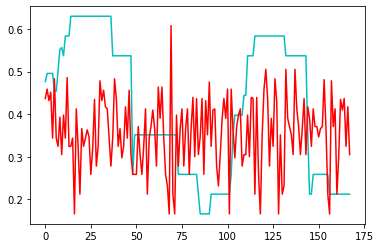

In [14]:
import matplotlib.pyplot as plt
import optimization
application_hours = 168
%store -r run_res_dict_1
%store -r run_res_dict_2
a = np.array(run_res_dict_1["recommended_schedule"]["total_energy_consumption_list"])
print(a)
b = np.array(run_res_dict_2["recommended_schedule"]["total_energy_consumption_list"])
print(b)
x = list(range(0,application_hours))
y = total_energy_consumption #geç ısıtma
z = res_dict[(10,14)][num_run]["recommended_schedule"]["total_energy_consumption_list"] #genetic algoritma
o = optimization.energy_list[:168]
#c = res_dict[(3,12)][num_run]["current_practice"]["total_energy_consumption_list"]
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(x, y, 'c')
plt.plot(x, z, 'r')
plt.plot(x, o, 'y')
plt.savefig('14_data_aralik_10_14_energy.png')
#plt.plot(x, c, 'g')
#plt.plot(range(len(a)), a, 'b')
#plt.plot(range(len(b)), b, 'o')

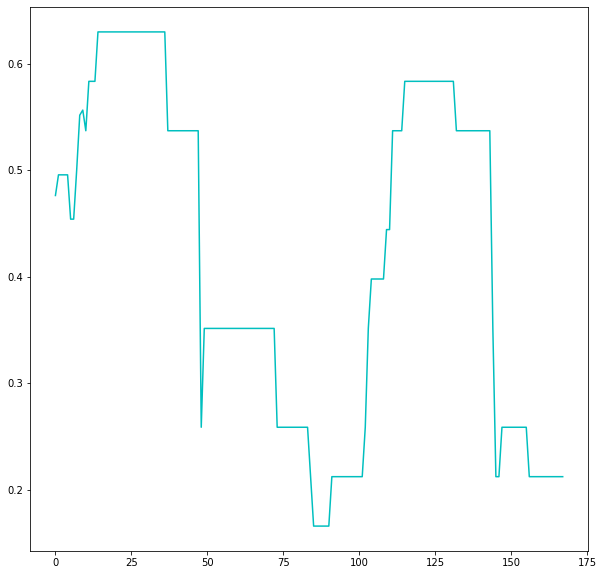

In [16]:
import matplotlib.pyplot as plt
import optimization
application_hours = 168

x = list(range(0,application_hours))
y = total_energy_consumption #geç ısıtma

plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(x, y, 'c')

plt.savefig('energy_consumption.pdf')
#plt.plot(x, c, 'g')
#plt.plot(range(len(a)), a, 'b')
#plt.plot(range(len(b)), b, 'o')

In [ ]:
improvement_target_list = demanded_temperature_list
energy_list = energy_sums.copy()
improvement_current_degrees = np.zeros(shape=final_mods.shape)
improvement_current_degrees = current_for_improvement
for i in range(final_mods.shape[0]):
        for j in range(final_mods.shape[1]):
                if final_mods[i,j] == 0:
                        continue
                elif final_mods[i,j] == 1:
                        improvement_current_degrees[i,j:final_mods.shape[1]] += (0.50-eps)
                elif final_mods[i,j] == 2:
                        improvement_current_degrees[i,j:final_mods.shape[1]] += (1.50-eps)
                else:
                        improvement_current_degrees[i,j:final_mods.shape[1]] += (10-eps)
improvement_delta_temps = calculate_delta_temp_list(improvement_current_degrees, improvement_target_list)
deltas = improvement_delta_temps.copy()
modulation_upper_limits = np.array([0.0,0.5-eps,1.5-eps,10.0-eps])
current_temperature = 1000
final_temperature = 1
cooling_rate = 0.95
for j in range(len(energy_list)-1, 1, -1):
        lowest_radiator = np.argmin(deltas[:,j])
        if improvement_current_degrees[lowest_radiator, j] - (modulation_upper_limits[int(final_mods[lowest_radiator, j])]-modulation_upper_limits[int(final_mods[lowest_radiator, j]-1)]) >=  improvement_target_list[i,j]:
                improvement_mods = final_mods.copy()
                improvement_mods[lowest_radiator, j] -= 1
                improvement_mods[lowest_radiator, j-1] += 1
                temp_cost, en_sums = cost_calculation(improvement_mods, VALVE_MODULATION_ENERGY_CONSUMPTIONS, boiler_inflection_point_list, BOILER_COSTS)
                if temp_cost < cost_berk:
                        final_mods = improvement_mods
                        cost_berk = temp_cost
                """
                else:
                        if current_temperature > final_temperature:
                                current_temperature = current_temperature*0.95
                                if random.random() < math.exp((temp_cost-cost_berk)/current_temperature):
                                        final_mods = improvement_mods
                                        cost_berk = temp_cost
                """
        
print("cost berk:", cost_berk)
print("final mods: ", final_mods)
print("column sums final:", final_mods.sum(axis=0))
print("en sums column sum: ", en_sums)


# Problem Based Construction Heuristic Single Run

In [ ]:
num_radiators = 3
application_period_in_hours = 6
print(f'Number of radiators: {num_radiators}')
print(f'Application period in hours: {application_period_in_hours}')

In [37]:
synth_batch_data = joblib.load('paper_synth_data.pk')
v = synth_batch_data[(num_radiators, application_period_in_hours)]

In [ ]:
"""
boiler_inflection_point_list = get_boiler_inflection_points(
  num_radiators, 
  VALVE_MODULATION_ENERGY_CONSUMPTIONS[-1]
)
"""
temperature_prediction_coef_list = get_temperature_prediction_coefficients(
  num_radiators
)
current_temperature_list = v['init_temp']
demanded_temperature_list = v['demanded_temp']
print('Initial temperatures:')
print(current_temperature_list)
print('Demanded temperatures:')
print(demanded_temperature_list)
print('#' * 100)
print()

In [ ]:
temperature_prediction_coef_list = get_temperature_prediction_coefficients(
    num_radiators
  )
demand_total_time = int(application_period_in_hours * DEMAND_GRANULARITY)
supply_total_time = int(application_period_in_hours * DEMAND_GRANULARITY / SUPPLY_GRANULARITY)
  
demanded_temperature_list = np.repeat(demanded_temperature_list, DEMAND_GRANULARITY).reshape(num_radiators, -1)
improvement_deneme(demanded_temperature_list, current_temperature_list, num_radiators, DEMAND_GRANULARITY*application_period_in_hours, temperature_prediction_coef_list, VALVE_MODULATION_LIMITS, 44, supply_granularity = SUPPLY_GRANULARITY, valve_modulation_limit_list = VALVE_MODULATION_LIMITS, valve_modulation_energy_consumption_list = VALVE_MODULATION_ENERGY_CONSUMPTIONS)

In [ ]:
z_list = qc_gurobi_code.z_list
print(z_list)